<a href="https://colab.research.google.com/github/Rishikesh-2006/NNs/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces/data?utm_source=chatgpt.com")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rishikesh1911sarma
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:11<00:00, 65.9MB/s]


In [63]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms

In [66]:
transform = transforms.Compose([
    transforms.centercrop(128),
    transforms.Resize((64,64)),
    transforms.ToTensor(),])
data = datasets.ImageFolder("/content/animal-faces/afhq/train/cats",transform=transform)


lat_dim = 100
channel = 3

In [67]:
#Architecture

class Dataset(Dataset):
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
  def __len__(self):
    return len(self.features)
  def __getitem__(self,i):
    return self.features[i],self.labels[i]


class GAN_Gen(nn.Module):
  def __init__(self):
    super().__init__()
    self.Gen = nn.Sequential(

          nn.ConvTranspose2d(lat_dim,512,4,stride=1,padding=0,bias=False),
          nn.BatchNorm2d(512),
          nn.ReLU(True),

          #size = (Batch_size,512,4,4)

          nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),
          nn.BatchNorm2d(256),
          nn.ReLU(True),

          #size = (Batch_size,256,8,8)

          nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),
          nn.BatchNorm2d(128),
          nn.ReLU(True),

          #size = (Batch_size,128,16,16)

          nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU(True),

          #size = (Batch_size,64,32,32)

          nn.ConvTranspose2d(64,channel,4,stride=2,padding =1,bias=False),
          nn.Tanh()

          #size = (Batch_size,3,64,64)
      )
  def forward(self,x):
    return self.Gen(x)


class GAN_Dis(nn.Module):
  def __init__(self):
    super().__init__()
    self.Dis = nn.Sequential(
          nn.Conv2d(channel,64,4,2,padding = 1,bias=False),
          nn.LeakyReLU(0.2,inplace = True),

          #size 32,32

          nn.Conv2d(64,128,4,2,padding=1,bias = False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2,inplace = True),

          #size 16,16

          nn.Conv2d(128,256,4,2,padding=1,bias = False),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2,inplace = True),

          #size 8,8

          nn.Conv2d(256,512,4,2,padding=1,bias = False),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2,inplace = True),

          #size 4,4

          nn.Conv2d(512,1,4,1,padding=0,bias = False),
          nn.Sigmoid()
      )
  def forward(self,x):
    return self.Dis(x).view(-1)

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data = DataLoader(data,batch_size=32,shuffle=True)

lr = 0.002
epochs = 50
batch_size = 32
criterion = nn.BCELoss()
Gen = GAN_Gen().to(device)
Gen_opt = optim.Adam(Gen.parameters(),lr = lr,betas=(0.5,0.999))

Dis = GAN_Dis().to(device)
Dis_opt = optim.Adam(Dis.parameters(),lr = lr,betas=(0.5,0.999))
print(device)


cuda


In [69]:
#Training
Gen.train()
Dis.train()
for epoch in range(epochs):
  DIS_LOSS = 0
  GEN_LOSS = 0

  for real_img ,_ in data:
    real_img = real_img.to(device)
    batch_size = real_img.size(0)

    fake_label = torch.zeros(batch_size,device=device)
    real_label = torch.ones(batch_size,device=device)

    noise = torch.randn(batch_size,lat_dim,1,1,device=device)
    fake_img = Gen(noise)

    #Discriminator training

    D_real = Dis(real_img)
    D_fake = Dis(fake_img.detach())

    loss1=criterion(D_real,real_label)
    loss2=criterion(D_fake,fake_label)
    loss_D = loss1 + loss2

    Dis_opt.zero_grad()
    loss_D.backward()
    Dis_opt.step()

    # Generator training

    Dis_fake = Dis(fake_img)

    loss_G = criterion(Dis_fake,real_label)
    Gen_opt.zero_grad()
    loss_G.backward()
    Gen_opt.step()

    DIS_LOSS += loss_D.item()
    GEN_LOSS += loss_G.item()
  print(f"epoch-{epoch+1}  Generator loss = {GEN_LOSS}  Discriminator loss = {DIS_LOSS}")






epoch-1  Generator loss = 445.809137403965  Discriminator loss = 257.82491479068995
epoch-2  Generator loss = 446.91353461146355  Discriminator loss = 219.47111009806395
epoch-3  Generator loss = 353.41583120822906  Discriminator loss = 224.64146375656128
epoch-4  Generator loss = 378.29237562417984  Discriminator loss = 220.34309339523315
epoch-5  Generator loss = 337.0525774359703  Discriminator loss = 217.36554193496704
epoch-6  Generator loss = 326.4591910839081  Discriminator loss = 215.35491180419922
epoch-7  Generator loss = 340.097638130188  Discriminator loss = 210.78173208236694
epoch-8  Generator loss = 288.0867766737938  Discriminator loss = 211.69913232326508
epoch-9  Generator loss = 305.9834464788437  Discriminator loss = 211.0473827123642
epoch-10  Generator loss = 350.2755924463272  Discriminator loss = 199.06276148557663
epoch-11  Generator loss = 322.8105785250664  Discriminator loss = 207.4123860001564
epoch-12  Generator loss = 298.04003578424454  Discriminator los

(32, 3, 64, 64)


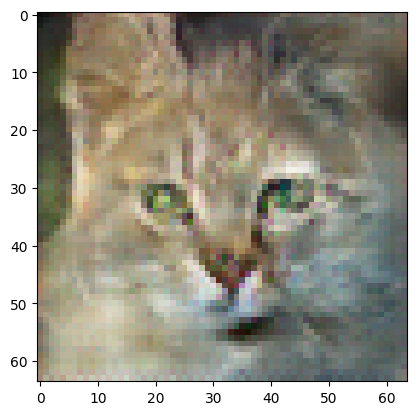

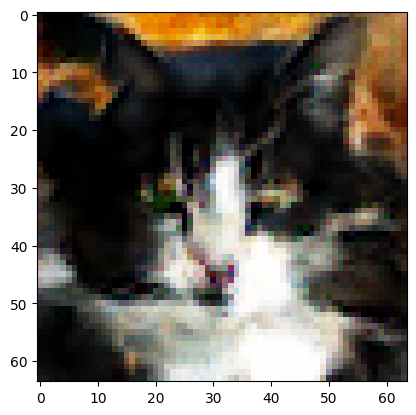

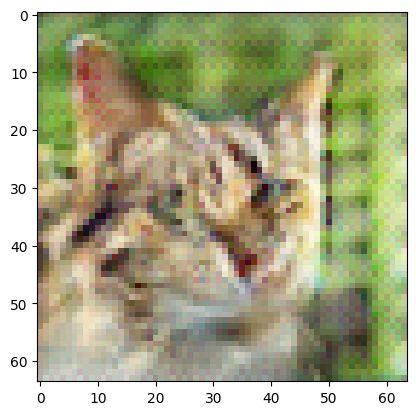

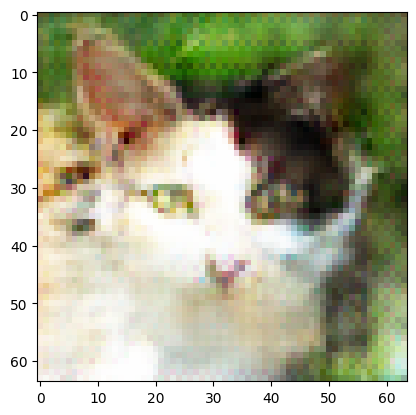

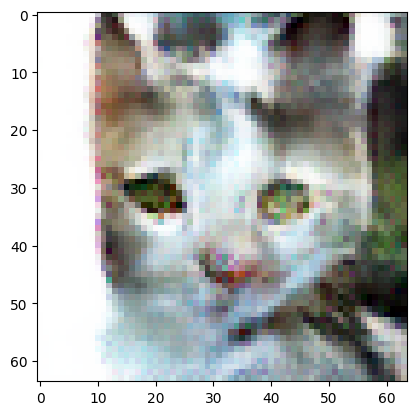

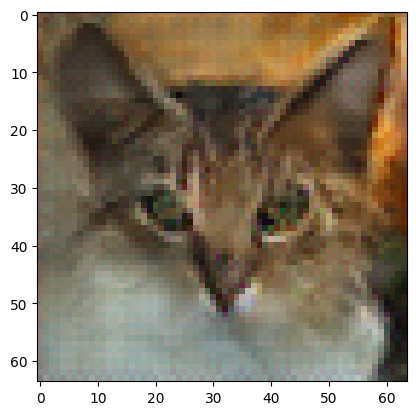

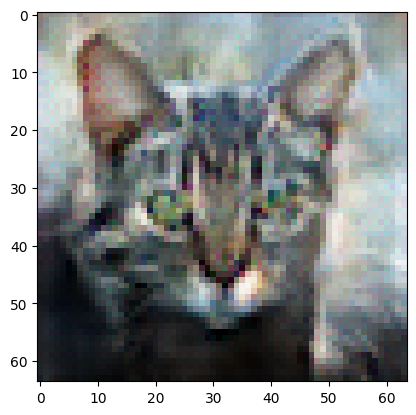

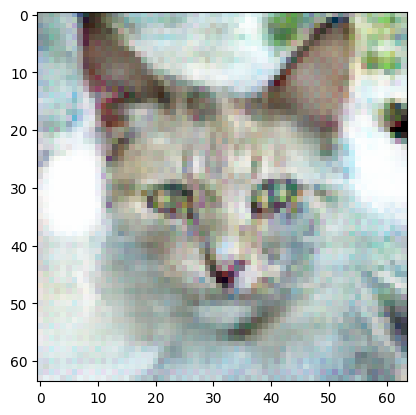

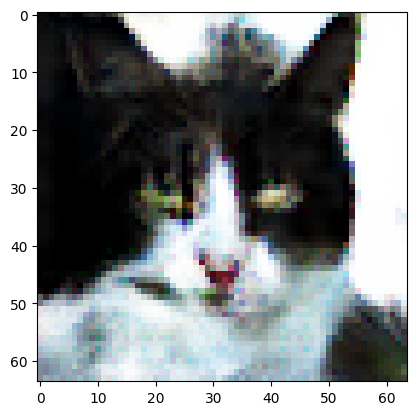

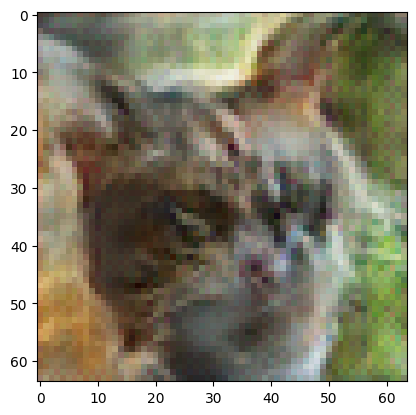

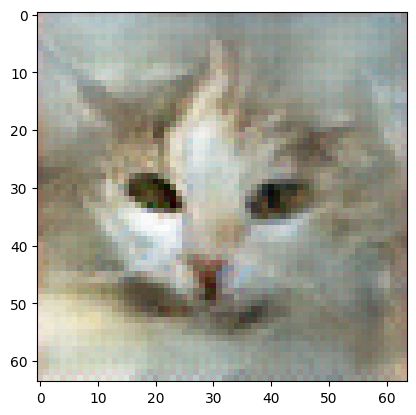

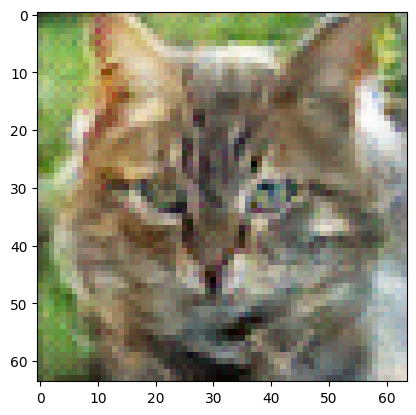

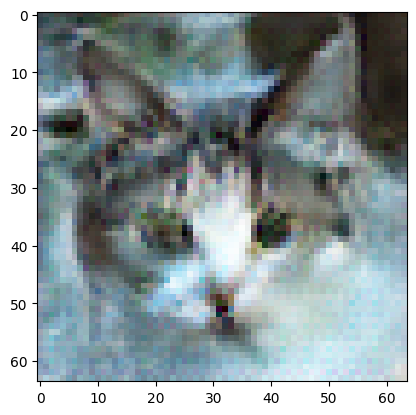

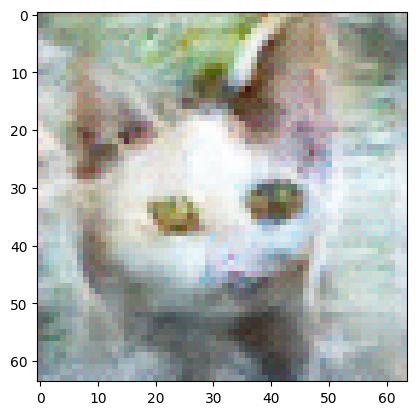

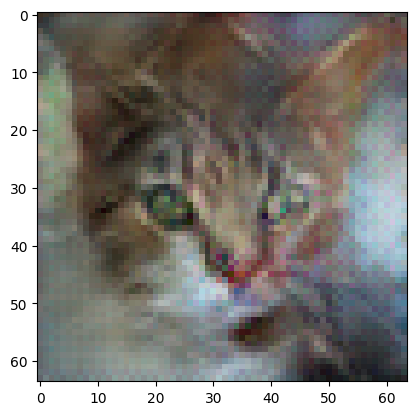

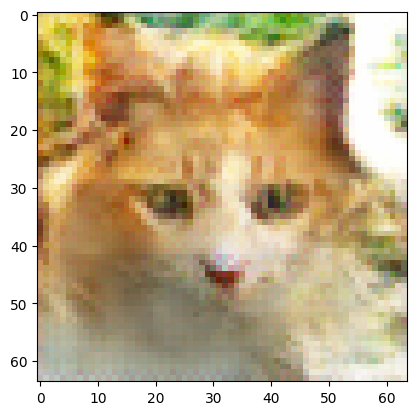

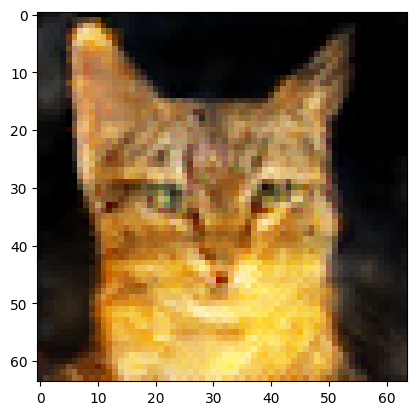

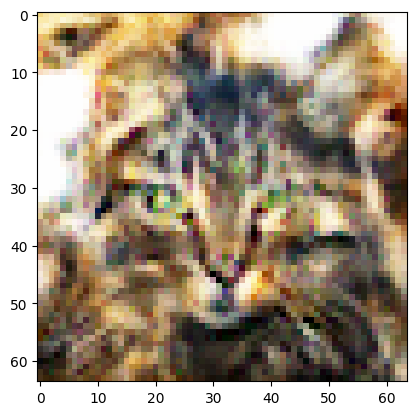

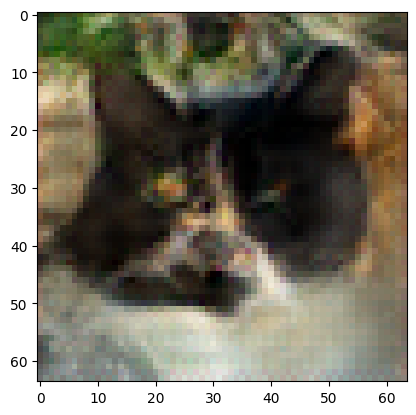

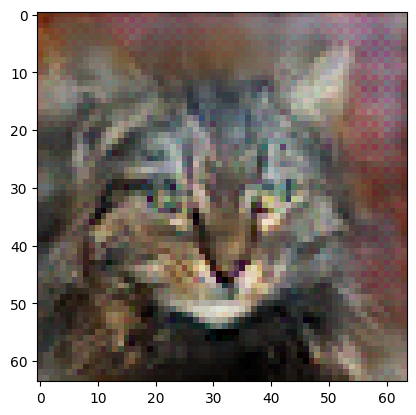

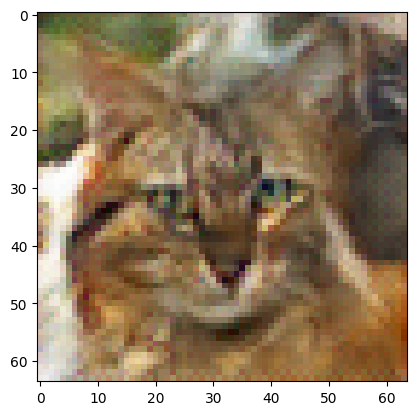

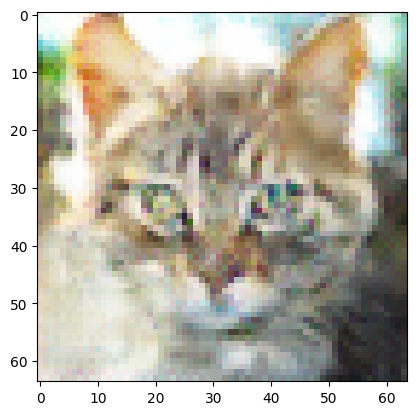

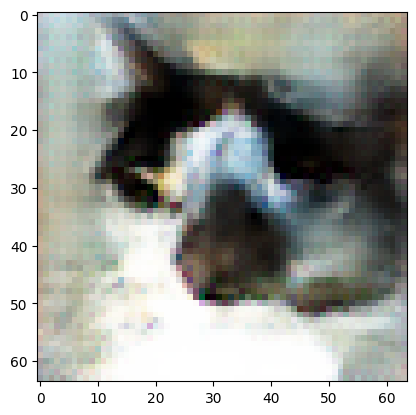

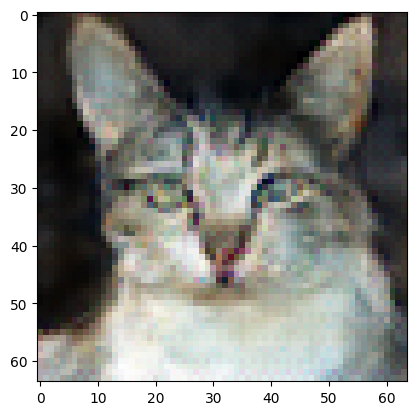

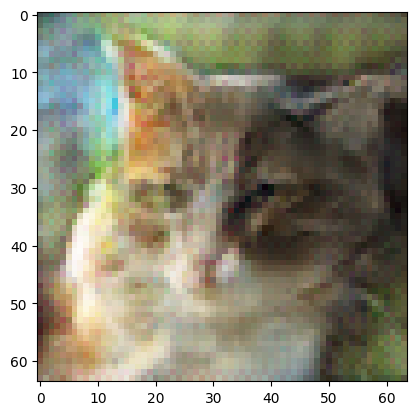

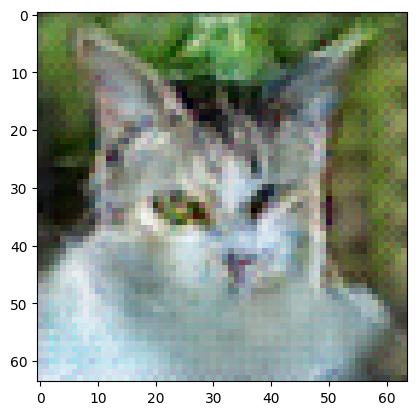

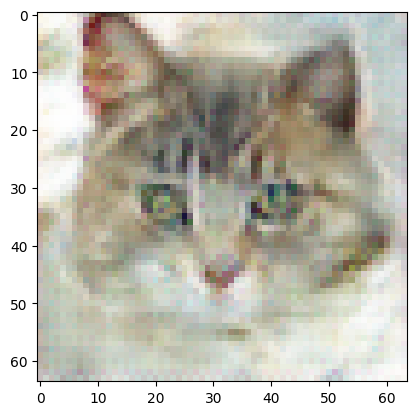

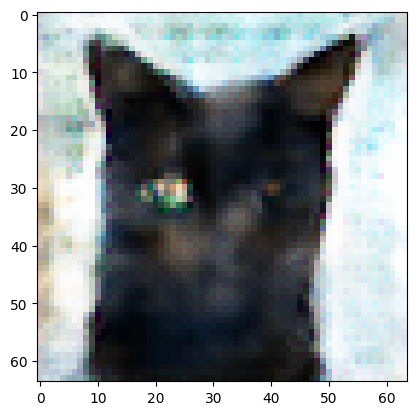

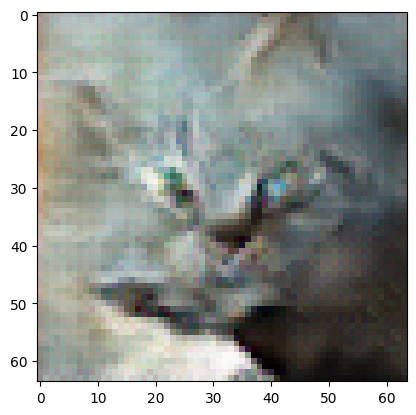

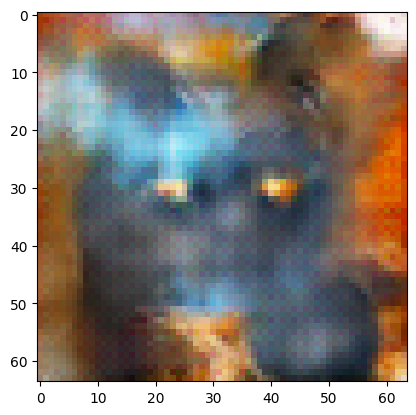

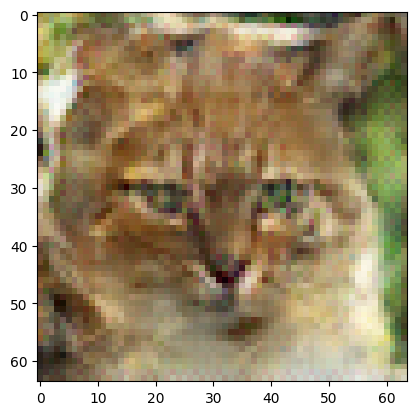

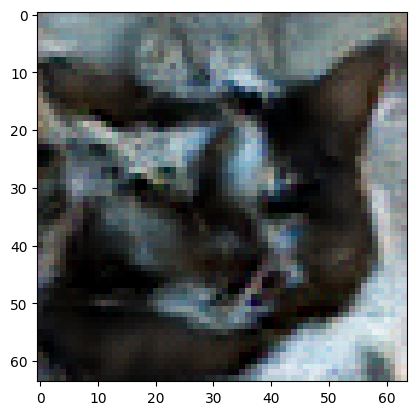

In [84]:
Gen.eval()
Dis.eval()
with torch.no_grad():
  noise = torch.randn(32,lat_dim,1,1,device=device)
  image = Gen(noise)
  im = image.detach()
  image = image.detach().cpu().numpy()

  print(image.shape)
  for i in range(32):
    plt.imshow(image[i].transpose(1,2,0))
    plt.show()



In [65]:
from google.colab import files
uploaded = files.upload()
print(uploaded)

{}
